# **QuantHedge-MM: Optimal Hedging in Markov Modulated Markets**

This notebook implements **QuantHedge-MM**, a Python-based framework for pricing and hedging options in markets characterized by **Markov-modulated regimes**. It generalizes the classical Black-Scholes model by allowing asset dynamics to evolve across multiple stochastic regimes, each defined by distinct parameters for volatility ($\sigma_i$), drift ($\mu_i$), and interest rate ($r_i$).

## **Model Dynamics**

* The asset price $S_t$ evolves as:

  $$
  dS_t = S_t \left( \mu(X_t) dt + \sigma(X_t) dW_t \right), \quad X_t \in \{1, 2, \dots, k\}
  $$

  where $X_t$ is a continuous-time Markov chain representing the regime, and its transitions are controlled by the generator matrix $\Lambda = [\lambda_{ij}]$.

## **Numerical Approach**

* Option prices $\varphi(t, s, i)$ are computed using an **integral equation**:

  $$
  \varphi(t,s,i) = \eta_i(t,s) + \int_t^T e^{-(r(i)+\lambda_i)(u-t)} \sum_{j \neq i} \lambda_{ij} \, \mathbb{E}[\varphi(u, S_u, j)] \, du
  $$
* The implementation includes:

  * Numba-accelerated **Monte Carlo simulation** for efficient computation.
  * A flexible solver for the integral equation governing the option prices.

## **Hedging and Risk Assessment**

* The notebook evaluates hedging performance via:

  * **Quadratic Residual Risk (QRR)**:

    $$
    \mathbb{E} \left[ \left( \int_0^T \xi_t \, dS_t - H(S_T) \right)^2 \right]
    $$
  * **Practitioner’s error**, measuring the discrepancy under discrete-time hedging strategies.

### **Applications**  
- Backtesting hedging strategies under regime shifts  
- Analyzing QRR/PRR trade-offs in volatile markets  
- Benchmarking against classical Black-Scholes  

In [1]:
!pip install yfinance numpy scipy matplotlib tqdm numba

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numba as nb

In [4]:
class MarkovModulatedHedging:
    def __init__(self, ticker='^GSPC', T=1.0, strike=None, num_time_grids=16, num_price_grids=300,
                 num_sim_steps=750, num_simulations=1000):
        """
        Initialize the hedging model with parameters

        Parameters:
        ticker: str - Yahoo Finance ticker symbol
        T: float - Time to maturity (in years)
        strike: float - Strike price (None for at-the-money)
        num_time_grids: int - Number of time grids for PDE solution
        num_price_grids: int - Number of price grids for PDE solution
        num_sim_steps: int - Number of steps in simulation
        num_simulations: int - Number of Monte Carlo simulations
        """
        self.T = T
        self.num_time_grids = num_time_grids
        self.num_price_grids = num_price_grids
        self.num_sim_steps = num_sim_steps
        self.num_simulations = num_simulations

        # Get current stock data
        print("Fetching stock data...")
        stock_data = yf.Ticker(ticker).history(period='1d')
        self.current_price = stock_data['Close'].iloc[-1]
        self.strike = strike if strike is not None else self.current_price
        print(f"Initialized with current price: {self.current_price:.2f}, strike: {self.strike:.2f}")

        # Markov regime parameters
        self.P = np.array([[0, 2/3, 1/3],
                          [1/2, 0, 1/2],
                          [1/3, 2/3, 0]])  # Transition matrix
        self.lambdas = np.array([1.0, 2.0, 1.0])  # Transition intensities
        self.mus = np.array([0.2, 0.6, 0.8])  # Drifts for each regime
        self.R = np.array([0.2, 0.5, 0.7])  # Interest rates for each regime
        self.SIG = np.array([0.2, 0.4, 0.3])  # Volatilities for each regime

        # Grid parameters
        self.dt = T / (num_time_grids - 1)
        self.max_price = 10 * self.strike
        self.dx = self.max_price / num_price_grids

        # Initialize arrays
        self.eta = np.zeros((num_time_grids, num_price_grids, 3))  # Black-Scholes prices
        self.u = np.zeros((num_time_grids, num_price_grids, 3))  # Option prices from integral equations
        self.du = np.zeros((num_time_grids, num_price_grids, 3))  # Hedging strategies
        self.psi = np.zeros((num_time_grids, num_price_grids, 3))  # Optimal hedging strategy

    def calculate_black_scholes(self):
        """Calculate Black-Scholes prices for all regimes, times and stock prices"""
        print("Calculating Black-Scholes prices...")
        # Standard normal CDF approximation
        x = np.linspace(-4, 4, 4000)
        SND = norm.cdf(x)

        for k in range(3):
            rp = self.R[k] + 0.5 * self.SIG[k]**2
            rm = self.R[k] - 0.5 * self.SIG[k]**2

            for i in range(1, self.num_time_grids):
                tm = i * self.dt  # time to expiry: T-t
                dn = self.SIG[k] * np.sqrt(tm)  # denominator

                for j in range(self.num_price_grids):
                    s = (j + 1) * self.dx  # stock price

                    # First term calculation
                    x_val = (np.log(s/self.strike) + rm * tm) / dn
                    if x_val > 4.0:
                        ph = 1.0
                    elif x_val < -4.0:
                        ph = 0.0
                    else:
                        xx = int(1000 * (4.0 + x_val))
                        ph = SND[xx] if x_val < 0 else 1 - SND[int(1000 * (4.0 - x_val))]

                    term = self.strike * np.exp(-self.R[k] * tm) * ph

                    # Second term calculation
                    y_val = (np.log(s/self.strike) + rp * tm) / dn
                    if y_val > 4.0:
                        ph = 1.0
                    elif y_val < -4.0:
                        ph = 0.0
                    else:
                        xx = int(1000 * (4.0 + y_val))
                        ph = SND[xx] if y_val < 0 else 1 - SND[int(1000 * (4.0 - y_val))]

                    self.eta[i, j, k] = s * ph - term
                    if j > 0:
                        self.du[i, :, k] = np.gradient(self.eta[i, :, k], self.dx)

        # Initial conditions
        for j in range(self.num_price_grids):
            for i in range(3):
                self.u[0, j, i] = max(0.0, (j + 1) * self.dx - self.strike)
                self.du[0, j, i] = max(np.sign((j + 1) * self.dx - self.strike), 0)
                self.eta[0, j, i] = max(0.0, (j + 1) * self.dx - self.strike)
                self.psi[0, j, i] = max(np.sign((j + 1) * self.dx - self.strike), 0)

    def solve_volterra_integral(self):
        """More precise implementation of Volterra integral equation solution"""
        print("Solving Volterra integral equations...")
        d = 1.0 / np.sqrt(2 * np.pi)

        # Precompute constants
        C12 = d / self.SIG
        C22 = d / (self.SIG**3)
        C11 = np.zeros((self.num_time_grids, 3))
        C21 = np.zeros((self.num_time_grids, 3))
        C3 = np.zeros((self.num_time_grids, 3))

        for i in range(3):
            for kk in range(1, self.num_time_grids):
                C11[kk, i] = (self.lambdas[i] * np.exp(-(self.R[i] + self.lambdas[i]) * (kk * self.dt)) / np.sqrt(kk * self.dt))
                C21[kk, i] = (self.lambdas[i] * np.exp(-(self.R[i] + self.lambdas[i]) * (kk * self.dt))) / (kk * self.dt)**1.5
                C3[kk, i] = np.exp(-self.lambdas[i] * kk * self.dt)

        # Calculate φ(t,s,i) for all t,s,i (Eq 2.15)
        for k in tqdm(range(1, self.num_time_grids), desc="Solving for φ(t,s,i)"):
            for j in range(self.num_price_grids):
                for i in range(3):
                    integral = 0
                    for kk in range(1, k + 1):
                        # Trapezoidal integration
                        sum_term = 0
                        for jj in range(self.num_price_grids):
                            weight = 1 if 0 < jj < self.num_price_grids - 1 else 0.5
                            x = (jj + 1) * self.dx
                            kernel = np.exp(-0.5 * ((np.log(x/((j + 1)*self.dx)) -
                                           (self.R[i] - 0.5*self.SIG[i]**2)*(kk*self.dt)) /
                                           (self.SIG[i]*np.sqrt(kk*self.dt)))**2)
                            phi_terms = np.sum([self.u[k - kk, jj, m] * self.P[i, m] for m in range(3)])
                            sum_term += weight * phi_terms * kernel / (x * np.sqrt(2*np.pi) * self.SIG[i] * np.sqrt(kk*self.dt))

                        integral += C11[kk, i] * sum_term * self.dx * self.dt

                    self.u[k, j, i] = C3[k, i] * self.eta[k, j, i] + integral

        # Calculate ψ(t,s,i) for all t,s,i
        for k in tqdm(range(1, self.num_time_grids), desc="Solving for ψ(t,s,i)"):
            for j in range(self.num_price_grids):
                for i in range(3):
                    integral = 0
                    for kk in range(1, k + 1):
                        # Trapezoidal integration
                        sum_term = 0
                        for jj in range(self.num_price_grids):
                            weight = 1 if 0 < jj < self.num_price_grids - 1 else 0.5
                            x = (jj + 1) * self.dx
                            log_term = np.log(x/((j + 1)*self.dx)) - (self.R[i] - 0.5*self.SIG[i]**2)*(kk*self.dt)
                            kernel = np.exp(-0.5 * (log_term / (self.SIG[i]*np.sqrt(kk*self.dt)))**2) * log_term
                            phi_terms = np.sum([self.u[k - kk, jj, m] * self.P[i, m] for m in range(3)])
                            sum_term += weight * phi_terms * kernel / (x * np.sqrt(2*np.pi) * self.SIG[i]**3 * (kk*self.dt)**1.5)

                        integral += C21[kk, i] * sum_term * self.dx * self.dt

                    self.psi[k, j, i] = C3[k, i] * self.du[k, j, i] + integral / ((j + 1) * self.dx)

    def solve_integral_equations(self):
        """Main method to solve all required integral equations"""
        self.calculate_black_scholes()
        self.solve_volterra_integral()

    @staticmethod
    @nb.njit
    def simulate_regime_switching_fast(lambdas, P, num_steps, dt, start_state):
        """Numba-accelerated regime switching simulation"""
        mark = np.zeros(num_steps + 1, dtype=np.int32)
        mark[0] = start_state

        for i in range(1, num_steps + 1):
            p1 = 1 - lambdas[mark[i-1]] * dt
            k2 = np.random.rand()

            if k2 <= p1:
                mark[i] = mark[i-1]
            else:
                current_state = mark[i-1]
                if current_state == 0:  # State 1
                    p11 = P[0, 1]
                    k11 = np.random.rand()
                    mark[i] = 1 if k11 <= p11 else 2
                elif current_state == 1:  # State 2
                    p11 = P[1, 0]
                    k11 = np.random.rand()
                    mark[i] = 0 if k11 <= p11 else 2
                else:  # State 3
                    p11 = P[2, 1]
                    k11 = np.random.rand()
                    mark[i] = 1 if k11 <= p11 else 0
        return mark

    def simulate_regime_switching(self, start_state):
        """Simulate the Markov regime switching process"""
        return self.simulate_regime_switching_fast(
            self.lambdas, self.P, self.num_sim_steps,
            self.T/self.num_sim_steps, start_state
        )

    def box_muller_normal(self, n):
        """Generate normal random variables using Box-Muller method"""
        U1 = np.random.rand(n)
        U2 = np.random.rand(n)
        Z = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
        return Z

    def simulate_stock_price(self, mark, start_price):
        """Simulate stock price process with regime switching"""
        stock = np.zeros(self.num_sim_steps + 1)
        stock[0] = start_price

        dt_sim = self.T / self.num_sim_steps
        W = np.zeros(self.num_sim_steps + 1)

        # Generate normal random variables using Box-Muller
        Z = self.box_muller_normal(self.num_sim_steps)

        for i in range(1, self.num_sim_steps + 1):
            dW = Z[i-1] * np.sqrt(dt_sim)
            W[i] = W[i-1] + self.mus[mark[i]] * dt_sim + self.SIG[mark[i]] * dW
            stock[i] = start_price * np.exp(W[i])

        return stock

    def calculate_holding_times(self, mark):
        """Calculate holding times in each regime"""
        changes = np.where(mark[:-1] != mark[1:])[0] + 1
        return changes, len(changes)

    def calculate_prices_in_simulation(self, stock_prices, mark):
        """Calculate option prices and hedging for simulated path"""
        eta1 = np.zeros(self.num_sim_steps + 1)
        u1 = np.zeros(self.num_sim_steps + 1)
        du1 = np.zeros(self.num_sim_steps + 1)
        Vu = np.zeros((self.num_sim_steps + 1, 3))  # Prices in all regimes

        # Create interpolators for each time step and regime
        x_grid = np.arange(1, self.num_price_grids + 1) * self.dx

        for t in range(self.num_sim_steps):
            s = stock_prices[t]
            if s >= self.max_price:
                eta1[t] = s - self.strike * np.exp(-self.R[mark[t]] * (self.T - t * self.T / self.num_sim_steps))
                u1[t] = s - self.strike * np.exp(-self.R[mark[t]] * (self.T - t * self.T / self.num_sim_steps))
                du1[t] = 1.0
                Vu[t, :] = s - self.strike * np.exp(-self.R * (self.T - t * self.T / self.num_sim_steps))
                continue

            # Find the time index in our precomputed solution
            time_idx = int((1 - t / self.num_sim_steps) * (self.num_time_grids - 1))
            time_idx = min(max(time_idx, 0), self.num_time_grids - 2)

            cf = (t % (self.num_sim_steps // (self.num_time_grids - 1))) / (self.num_sim_steps // (self.num_time_grids - 1))

            # Interpolate for current regime
            for regime in range(3):
                interp_u = interp1d(x_grid, self.u[time_idx, :, regime], bounds_error=False, fill_value="extrapolate")
                Vu[t, regime] = (1 - cf) * interp_u(s) + cf * interp_u(s)

            interp_eta = interp1d(x_grid, self.eta[time_idx, :, mark[t]], bounds_error=False, fill_value="extrapolate")
            interp_u = interp1d(x_grid, self.u[time_idx, :, mark[t]], bounds_error=False, fill_value="extrapolate")
            interp_du = interp1d(x_grid, self.du[time_idx, :, mark[t]], bounds_error=False, fill_value="extrapolate")

            eta1[t] = (1 - cf) * interp_eta(s) + cf * interp_eta(s)
            u1[t] = (1 - cf) * interp_u(s) + cf * interp_u(s)
            du1[t] = (1 - cf) * interp_du(s) + cf * interp_du(s)

        # Final time step
        s = stock_prices[-1]
        if s >= self.max_price:
            eta1[-1] = max(s - self.strike, 0)
            u1[-1] = max(s - self.strike, 0)
            du1[-1] = 1.0 if s > self.strike else 0.0
            Vu[-1, :] = max(s - self.strike, 0)
        else:
            for regime in range(3):
                interp_u = interp1d(x_grid, self.u[0, :, regime], bounds_error=False, fill_value="extrapolate")
                Vu[-1, regime] = interp_u(s)

            interp_eta = interp1d(x_grid, self.eta[0, :, mark[-1]], bounds_error=False, fill_value="extrapolate")
            interp_u = interp1d(x_grid, self.u[0, :, mark[-1]], bounds_error=False, fill_value="extrapolate")
            interp_du = interp1d(x_grid, self.du[0, :, mark[-1]], bounds_error=False, fill_value="extrapolate")

            eta1[-1] = interp_eta(s)
            u1[-1] = interp_u(s)
            du1[-1] = interp_du(s)

        return eta1, u1, du1, Vu

    def calculate_error(self, mark, stock_prices, u1, Vu, holding_times, num_changes):
        """Calculate the quadratic risk measure"""
        dt_sim = self.T / self.num_sim_steps
        IN = 0.0

        if num_changes == 0:
            tt2 = self.num_sim_steps + 1
        else:
            tt2 = holding_times[0]

        tt1 = 0
        j = mark[0]

        for kt in range(tt2):
            y = kt * dt_sim
            term1 = 0
            for jj in range(3):
                term1 += self.P[j, jj] * (Vu[kt, jj] - u1[kt])**2
            IN += np.exp(-2 * self.R[j] * y) * self.lambdas[j] * term1

        disc = 1.0

        if num_changes >= 1:
            for k in range(num_changes):
                disc *= np.exp(-2 * self.R[mark[k]] * (tt2 - tt1) * dt_sim)
                tt1 = holding_times[k]

                if num_changes == k + 1:
                    tt2 = self.num_sim_steps + 1
                else:
                    tt2 = holding_times[k + 1]

                j = mark[k + 1]

                for kt in range(tt1, tt2):
                    y = (kt - tt1) * dt_sim
                    term1 = 0
                    for jj in range(3):
                        term1 += self.P[j, jj] * (Vu[kt, jj] - u1[kt])**2
                    IN += disc * np.exp(-2 * self.R[j] * y) * self.lambdas[j] * term1

        return IN * dt_sim

    def calculate_positive_residual_risk(self, mark, stock_prices, u1, Vu, holding_times, num_changes):
        """Calculate positive residual risk"""
        dt_sim = self.T / self.num_sim_steps
        IN_plus = 0.0

        if num_changes == 0:
            tt2 = self.num_sim_steps + 1
        else:
            tt2 = holding_times[0]

        tt1 = 0
        j = mark[0]

        for kt in range(tt2):
            y = kt * dt_sim
            term1 = 0
            for jj in range(3):
                diff = Vu[kt, jj] - u1[kt]
                term1 += self.P[j, jj] * (max(diff, 0))**2  # Only positive differences
            IN_plus += np.exp(-2 * self.R[j] * y) * self.lambdas[j] * term1

        disc = 1.0

        if num_changes >= 1:
            for k in range(num_changes):
                disc *= np.exp(-2 * self.R[mark[k]] * (tt2 - tt1) * dt_sim)
                tt1 = holding_times[k]

                if num_changes == k + 1:
                    tt2 = self.num_sim_steps + 1
                else:
                    tt2 = holding_times[k + 1]

                j = mark[k + 1]

                for kt in range(tt1, tt2):
                    y = (kt - tt1) * dt_sim
                    term1 = 0
                    for jj in range(3):
                        diff = Vu[kt, jj] - u1[kt]
                        term1 += self.P[j, jj] * (max(diff, 0))**2  # Only positive differences
                    IN_plus += disc * np.exp(-2 * self.R[j] * y) * self.lambdas[j] * term1

        return IN_plus * dt_sim

    def enhanced_practitioner_error(self, mark, stock_prices, u1, du1):
        """More accurate implementation of practitioner's approach"""
        dt_sim = self.T / self.num_sim_steps
        Vt = u1[0]  # Initial option price
        Bt = 1.0  # Bank account process

        for i in range(self.num_sim_steps):
            # Update bank account
            Bt *= np.exp(self.R[mark[i]] * dt_sim)

            # Calculate discounted stock price
            S_star = stock_prices[i] / Bt

            # Update portfolio value (using ψ for hedging)
            Vt += du1[i] * (stock_prices[i+1]/Bt - stock_prices[i]/Bt)

        # Final payoff
        final_payoff = max(0.0, stock_prices[-1] - self.strike) / Bt
        error = Vt - final_payoff
        return error

    def plot_regime_switching(self, mark):
        """Plot regime switching process"""
        plt.figure(figsize=(10, 6))
        plt.step(range(len(mark)), mark, where='post', linewidth=2)
        plt.title("Regime Switching Process", fontsize=14)
        plt.ylabel("Regime State", fontsize=12)
        plt.xlabel("Time Step", fontsize=12)
        plt.yticks([0, 1, 2], ["Regime 1", "Regime 2", "Regime 3"])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_stock_price(self, stock_prices):
        """Plot stock price process"""
        plt.figure(figsize=(10, 6))
        plt.plot(stock_prices, linewidth=2)
        plt.title("Stock Price Process", fontsize=14)
        plt.ylabel("Stock Price", fontsize=12)
        plt.xlabel("Time Step", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_option_price(self, option_prices):
        """Plot option price process"""
        plt.figure(figsize=(10, 6))
        plt.plot(option_prices, linewidth=2)
        plt.title("Option Price Process", fontsize=14)
        plt.ylabel("Option Price", fontsize=12)
        plt.xlabel("Time Step", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_hedging_strategy(self, hedging_strategy):
        """Plot hedging process"""
        plt.figure(figsize=(10, 6))
        plt.plot(hedging_strategy, linewidth=2)
        plt.title("Hedging Strategy Process", fontsize=14)
        plt.ylabel("Delta (ψ)", fontsize=12)
        plt.xlabel("Time Step", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_risk_comparison(self, price_grid, quad_risk, pos_risk, pract_error):
        """Plot risk measures"""
        plt.figure(figsize=(15, 10))

        # Quadratic Residual Risk
        plt.subplot(2, 2, 1)
        for regime in range(3):
            plt.plot(price_grid, quad_risk[regime, :],
                    label=f'Regime {regime+1}', linewidth=2)
        plt.title("Quadratic Residual Risk", fontsize=12)
        plt.xlabel("Initial Stock Price")
        plt.ylabel("Risk")
        plt.legend()
        plt.grid(True)

        # Positive Residual Risk
        plt.subplot(2, 2, 2)
        for regime in range(3):
            plt.plot(price_grid, pos_risk[regime, :],
                    label=f'Regime {regime+1}', linewidth=2)
        plt.title("Positive Residual Risk", fontsize=12)
        plt.xlabel("Initial Stock Price")
        plt.ylabel("Risk")
        plt.legend()
        plt.grid(True)

        # Practitioner Quadratic Risk
        plt.subplot(2, 2, 3)
        for regime in range(3):
            plt.plot(price_grid, (pract_error[regime, :])**2,
                    label=f'Regime {regime+1}', linewidth=2)
        plt.title("Practitioner Quadratic Risk", fontsize=12)
        plt.xlabel("Initial Stock Price")
        plt.ylabel("Risk")
        plt.legend()
        plt.grid(True)

        # Practitioner Positive Risk
        plt.subplot(2, 2, 4)
        for regime in range(3):
            plt.plot(price_grid, np.maximum(pract_error[regime, :], 0)**2,
                    label=f'Regime {regime+1}', linewidth=2)
        plt.title("Practitioner Positive Risk", fontsize=12)
        plt.xlabel("Initial Stock Price")
        plt.ylabel("Risk")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run_complete_simulation(self, start_price, start_regime):
        """Enhanced simulation with all risk measures"""
        # Simulate regime switching
        mark = self.simulate_regime_switching(start_regime)

        # Simulate stock price
        stock_prices = self.simulate_stock_price(mark, start_price)

        # Calculate prices along path
        eta1, u1, du1, Vu = self.calculate_prices_in_simulation(stock_prices, mark)

        # Calculate holding times
        holding_times, num_changes = self.calculate_holding_times(mark)

        # Calculate all risk measures
        quad_risk = self.calculate_error(mark, stock_prices, u1, Vu, holding_times, num_changes)
        pos_risk = self.calculate_positive_residual_risk(mark, stock_prices, u1, Vu, holding_times, num_changes)
        pract_error = self.enhanced_practitioner_error(mark, stock_prices, u1, du1)

        return {
            'stock_prices': stock_prices,
            'regimes': mark,
            'option_prices': u1,
            'hedging_strategy': du1,
            'quadratic_risk': quad_risk,
            'positive_risk': pos_risk,
            'practitioner_error': pract_error
        }

    def monte_carlo_simulation(self, start_price_range=None, num_points=50):
        """Enhanced Monte Carlo with all risk measures"""
        if start_price_range is None:
            start_price_range = [0.5 * self.strike, 1.5 * self.strike]

        price_grid = np.linspace(start_price_range[0], start_price_range[1], num_points)
        expected_quad_risk = np.zeros((3, num_points))
        expected_pos_risk = np.zeros((3, num_points))
        expected_pract_error = np.zeros((3, num_points))

        # Precompute the PDE solutions
        self.solve_integral_equations()

        for regime in range(3):
            print(f"\nRunning simulations for regime {regime + 1}...")
            for i, start_price in enumerate(tqdm(price_grid, desc=f"Regime {regime + 1}")):
                total_quad = 0
                total_pos = 0
                total_pract = 0
                valid_simulations = 0

                for _ in range(self.num_simulations):
                    # Run complete simulation
                    sim_results = self.run_complete_simulation(start_price, regime)

                    # Discard paths that go above max price
                    if np.any(sim_results['stock_prices'] > self.max_price):
                        continue

                    valid_simulations += 1
                    total_quad += sim_results['quadratic_risk']
                    total_pos += sim_results['positive_risk']
                    total_pract += sim_results['practitioner_error']

                if valid_simulations > 0:
                    expected_quad_risk[regime, i] = total_quad / valid_simulations
                    expected_pos_risk[regime, i] = total_pos / valid_simulations
                    expected_pract_error[regime, i] = total_pract / valid_simulations
                else:
                    expected_quad_risk[regime, i] = np.nan
                    expected_pos_risk[regime, i] = np.nan
                    expected_pract_error[regime, i] = np.nan

        return price_grid, expected_quad_risk, expected_pos_risk, expected_pract_error

Fetching stock data...
Initialized with current price: 5913.23, strike: 5913.23
Calculating Black-Scholes prices...
Solving Volterra integral equations...


Solving for φ(t,s,i):   0%|          | 0/14 [00:00<?, ?it/s]

Solving for ψ(t,s,i):   0%|          | 0/14 [00:00<?, ?it/s]


Running simulations for regime 1...


Regime 1:   0%|          | 0/20 [00:00<?, ?it/s]


Running simulations for regime 2...


Regime 2:   0%|          | 0/20 [00:00<?, ?it/s]


Running simulations for regime 3...


Regime 3:   0%|          | 0/20 [00:00<?, ?it/s]

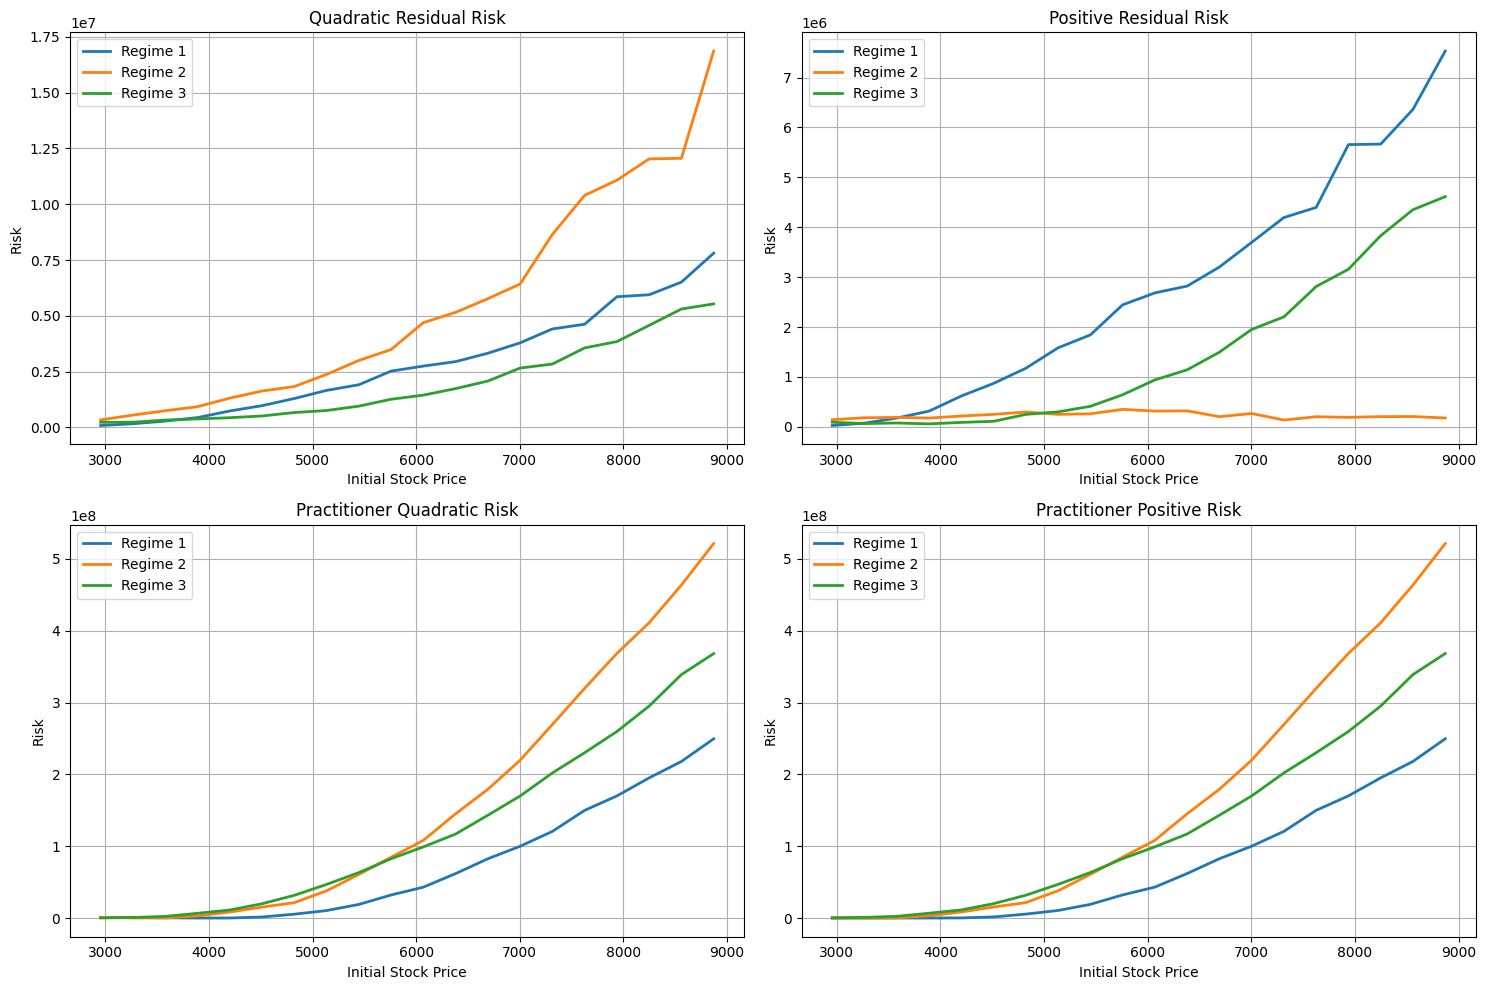

In [6]:
# Initialize and run the enhanced model
model = MarkovModulatedHedging(ticker='^GSPC', T=1.0,
                              num_time_grids=15,
                              num_price_grids=100,
                              num_simulations=100)

# Run Monte Carlo simulations
price_grid, quad_risk, pos_risk, pract_error = model.monte_carlo_simulation(num_points=20)

# Plot all risk comparisons
model.plot_risk_comparison(price_grid, quad_risk, pos_risk, pract_error)


Running sample simulation...


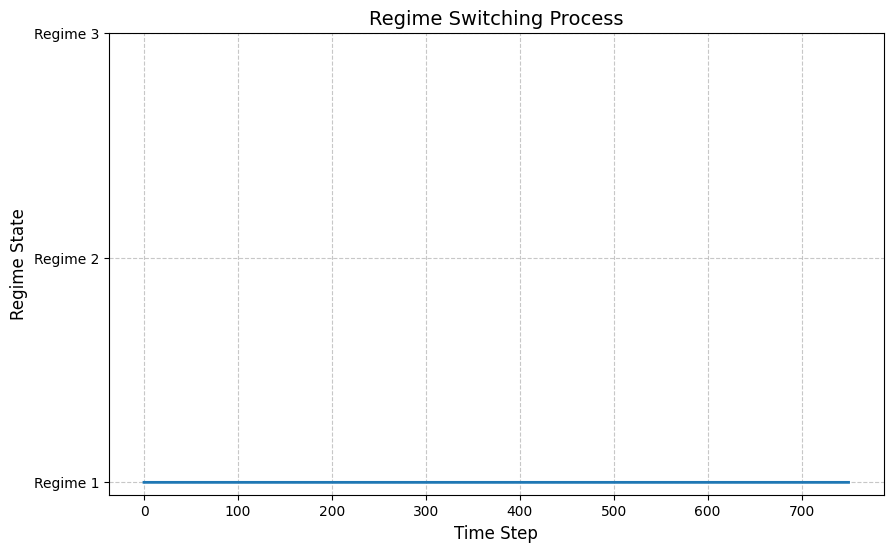

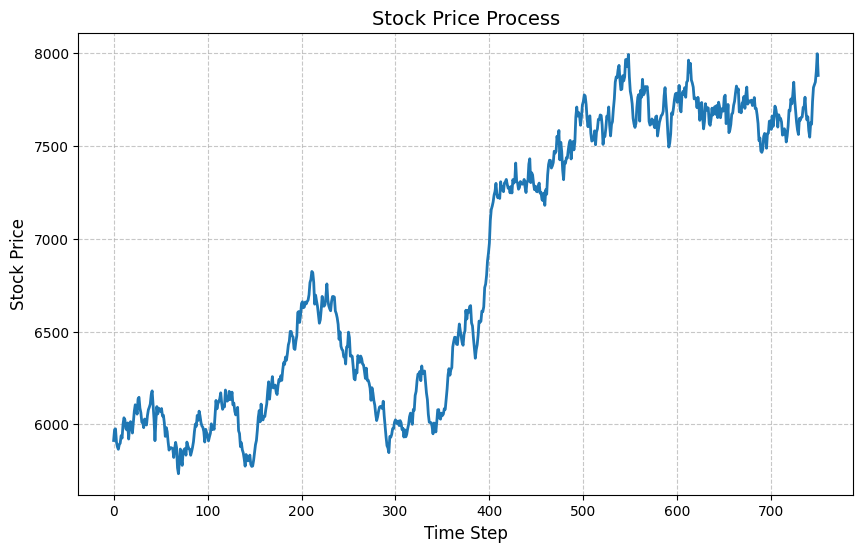

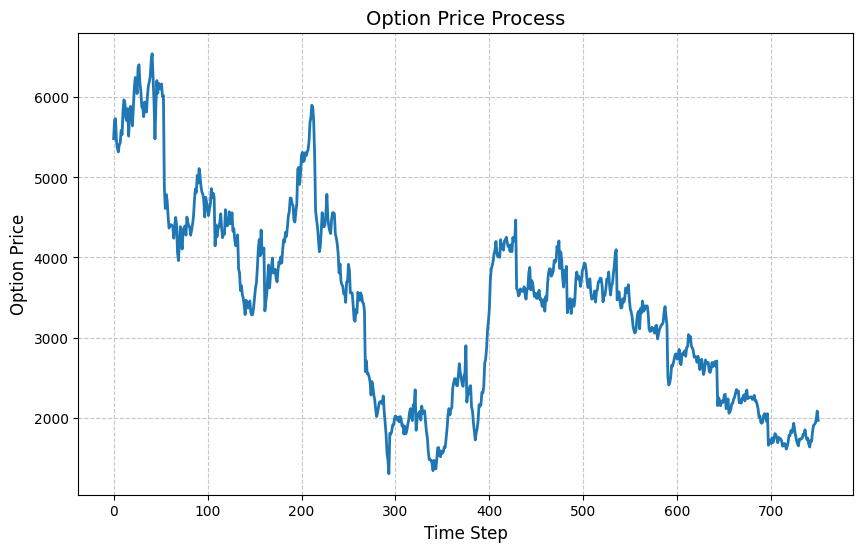

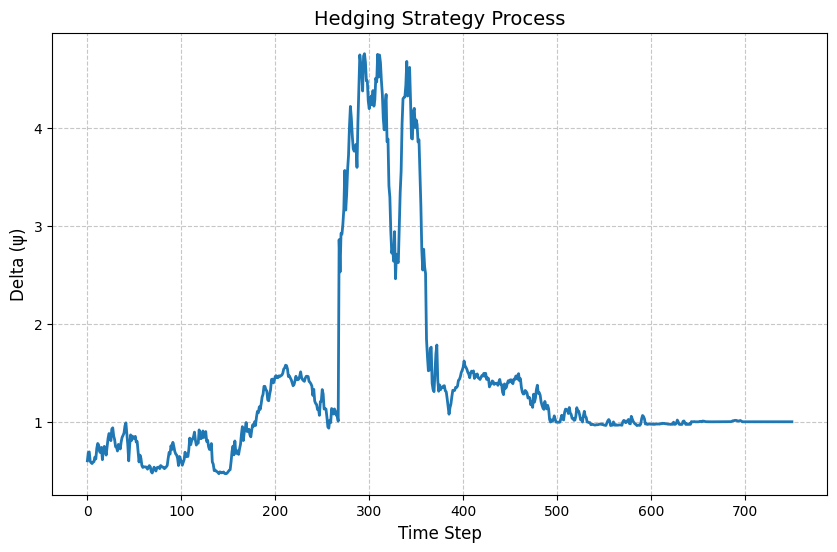


Error Comparison for Sample Path:
Quadratic Risk: 2710720.302566
Positive Residual Risk: 2710720.302566
Practitioner Error: 6470.214950


In [7]:
# Run and plot a sample simulation
print("\nRunning sample simulation...")
sim_results = model.run_complete_simulation(model.current_price, 0)

model.plot_regime_switching(sim_results['regimes'])
model.plot_stock_price(sim_results['stock_prices'])
model.plot_option_price(sim_results['option_prices'])
model.plot_hedging_strategy(sim_results['hedging_strategy'])

# Print error comparison
print("\nError Comparison for Sample Path:")
print(f"Quadratic Risk: {sim_results['quadratic_risk']:.6f}")
print(f"Positive Residual Risk: {sim_results['positive_risk']:.6f}")
print(f"Practitioner Error: {sim_results['practitioner_error']:.6f}")